# Visualising UNET #

### Abstract ###

- Self explained. Using `torch_view` as main library.
- The docuement below is mainly copied from [mega_cmp.ipynb](./v2a/mmega_cmp.ipynb)

### Required libraries ###

- ~~Should be the common ML pack we're using. Also with [SD webui's dependency](https://github.com/AUTOMATIC1111/stable-diffusion-webui).~~

- [torchview](https://torchview.dev/)
- [scikit-learn](https://scikit-learn.org/stable/install.html)
- [NetworkX](https://networkx.org/documentation/stable/release/release_3.0.html)
- [safetensors](https://huggingface.co/docs/safetensors/index)
- [diffusers](https://huggingface.co/docs/diffusers/installation)
- [omegaconf](https://anaconda.org/conda-forge/omegaconf)
- [pytorch](https://pytorch.org/get-started/locally/#windows-python)
- [matplotlib](https://matplotlib.org/stable/api/matplotlib_configuration_api.html)
- [numpy](https://numpy.org/)
- [torchinfo](https://pypi.org/project/torchinfo/)

### Some layer name to interprept (for SD1.5) ###
- `first_stage_model`: VAE
- `cond_stage_model`: Text Encoder
- `model.diffusion_model`: Diffusion model
- `model_ema`: EMA model for training
- `cumprod`, `betas`, `alphas`: `CosineAnnealingLR`

### Some notation (Useful in the bin chart) ###
- `attn1`: `sattn` = *Self attention*
- `attn2`: `xattn` = *Cross attention*
- `ff`: *Feed forward*
- `norm`: [Normalisation layer](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html). `elementwise_affine=True` introduces trainable `bias` and `weight`. 
- `proj`: *Projection*
- `emb_layers`: *Embedding layers*
- `others`: `ff` + `norm` + `proj` + `emb_layers`

## Importing libraries ##

In [20]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)

# IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import glob
import os
import csv
import string
from pathlib import Path
random.seed(100)
import pandas as pd
# import xgboost as xgb
from scipy import stats

import torch
from safetensors.torch import load_file, load_model #safe_open
from diffusers import UNet2DConditionModel, DiffusionPipeline, StableDiffusionPipeline

from torchview import draw_graph
from torchinfo import summary

import graphviz
graphviz.set_jupyter_format('png')

'svg'

In [2]:
torch.__version__

'2.0.1+cu118'

In [3]:
# Fix for OMP: Error #15
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [4]:
# TODO: Support 'cuda', but 'cpu' is arleady fast.
g_device = "cuda:0" #"cpu"
# Currently for generating graph only.
g_seed = 114514

In [5]:
# Model path
model_path = {
    #"sd1": "../../stable-diffusion-webui/tmp/view_unet/21b-AstolfoMix-2020b.safetensors",
    #"sd2": "../../stable-diffusion-webui/tmp/view_unet/wd-1-5-beta2-fp16.safetensors",
    #"sdxl": "../../stable-diffusion-webui/tmp/view_unet/wdxl-aesthetic-0.9.safetensors"
}

Read model

In [6]:
def custom_load_model(path: str, device: str, print_ptl_info=False): # -> dict[str, torch.Tensor]
    if ".safetensors" in path:
        #return StableDiffusionPipeline.from_single_file(path, device=device, torch_dtype=torch.float16,use_safetensors=True)
        return load_file(path, device=device)
    else:
        #return StableDiffusionPipeline.from_single_file(path, device=device, torch_dtype=torch.float16,use_safetensors=False)
        #raise Exception("ckpt is not supprted.")
        ckpt = torch.load(path, map_location=device)
        if print_ptl_info and "epoch" in ckpt and "global_step" in ckpt:
            print(f"[I] {path.name}: epoch {ckpt['epoch']}, step {ckpt['global_step']}")
        return ckpt["state_dict"] if "state_dict" in ckpt else ckpt

In [7]:
model_instance = None # Clear
model_instance = {} # Clear
for k in model_path.keys():
    print("Loading {}".format(k))
    model_instance[k] = custom_load_model(model_path[k], g_device, False)

In [8]:
def get_input_size(model):
    layer_list = model.keys()
    first_layer = list(layer_list)[0]
    return model[first_layer].size()

In [9]:
for k in model_path.keys():
    print("{}: {}".format(k, get_input_size(model_instance[k])))

In [10]:
def is_sdxl(model):
    for layer_name in model.keys():
        if "conditioner" in layer_name:
            return True
    return False 

def is_sd2(model):
    for layer_name in model.keys():
        if "cond_stage_model.model" in layer_name:
            return True
    return False 

def is_sd1(model):
    for layer_name in model.keys():
        if "cond_stage_model.transformer" in layer_name:
            return True
    return False

Model metadata is assumed `None`. However SD type can be detected. See [load_model_weights](https://github.com/AUTOMATIC1111/stable-diffusion-webui/blob/master/modules/sd_models.py#L336C1-L410). Assumed this model is a valid SD model.

*Nope, it is code dependent. I used my method instead. It is also proven in mega_cmp.*

In [11]:
def guess_sd_type(model):
    if is_sdxl(model):
        return "sdxl"
    elif is_sd2(model):
        return "sd2"
    elif is_sd1(model):
        return "sd1"
    else:
        # RIP NMFSAN
        raise Exception("Invalid SD model: CLIP is missing")

In [12]:
for k in model_path.keys():
    print("{}: {}".format(k, guess_sd_type(model_instance[k])))

Now it is the hardest part: `torchview` requires a legit `nn.Module` with `model.training`, which is absent from any SD model. 

It is once mentioned in [kohya-ss / sd-scripts](https://github.com/kohya-ss/sd-scripts/blob/main/library/original_unet.py), but it is custom made. 

Luckily [CCRcmcpe/scal-sdt](https://github.com/CCRcmcpe/scal-sdt/blob/main/modules/model.py) has a `diffuser` implementation which is a lot more elegent. See [loading safetensors with diffusers.](https://huggingface.co/docs/diffusers/using-diffusers/using_safetensors)

However `load_single_file` is failed (versioning hell, omitted). I load online model instead.

In [13]:
unet = UNet2DConditionModel.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="unet").to(g_device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [14]:
#unet.sample_size

In [19]:
summary(unet, input_data={
    'sample': torch.rand(320, 4, 3, 3).to(g_device),
    'timestep': torch.rand(320).to(g_device),
    'encoder_hidden_states': torch.rand(320, 1, 768).to(g_device),
}, col_names=("input_size", "output_size", "num_params"))

Layer (type:depth-idx)                                                           Input Shape               Output Shape              Param #
UNet2DConditionModel                                                             --                        [320, 4, 3, 3]            --
├─Timesteps: 1-1                                                                 [320]                     [320, 320]                --
├─TimestepEmbedding: 1-2                                                         [320, 320]                [320, 1280]               1,639,680
│    └─LoRACompatibleLinear: 2-1                                                 [320, 320]                [320, 1280]               410,880
├─SiLU: 1-3                                                                      [320, 1280]               [320, 1280]               --
├─TimestepEmbedding: 1-4                                                         --                        --                        (recursive)
│    └─LoRACompatibleL

In [41]:
png = draw_graph(unet, input_data={
    'sample': torch.rand(320, 4, 3, 3).to(g_device),
    'timestep': torch.rand(320).to(g_device),
    'encoder_hidden_states': torch.rand(320, 1, 768).to(g_device),
}, graph_name="runwayml/stable-diffusion-v1-5",  device=g_device, mode="eval", depth=1, roll=True, expand_nested=True) #, hide_inner_tensors=False


(process:19788): Pango-WARNING **: 02:26:07.266: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


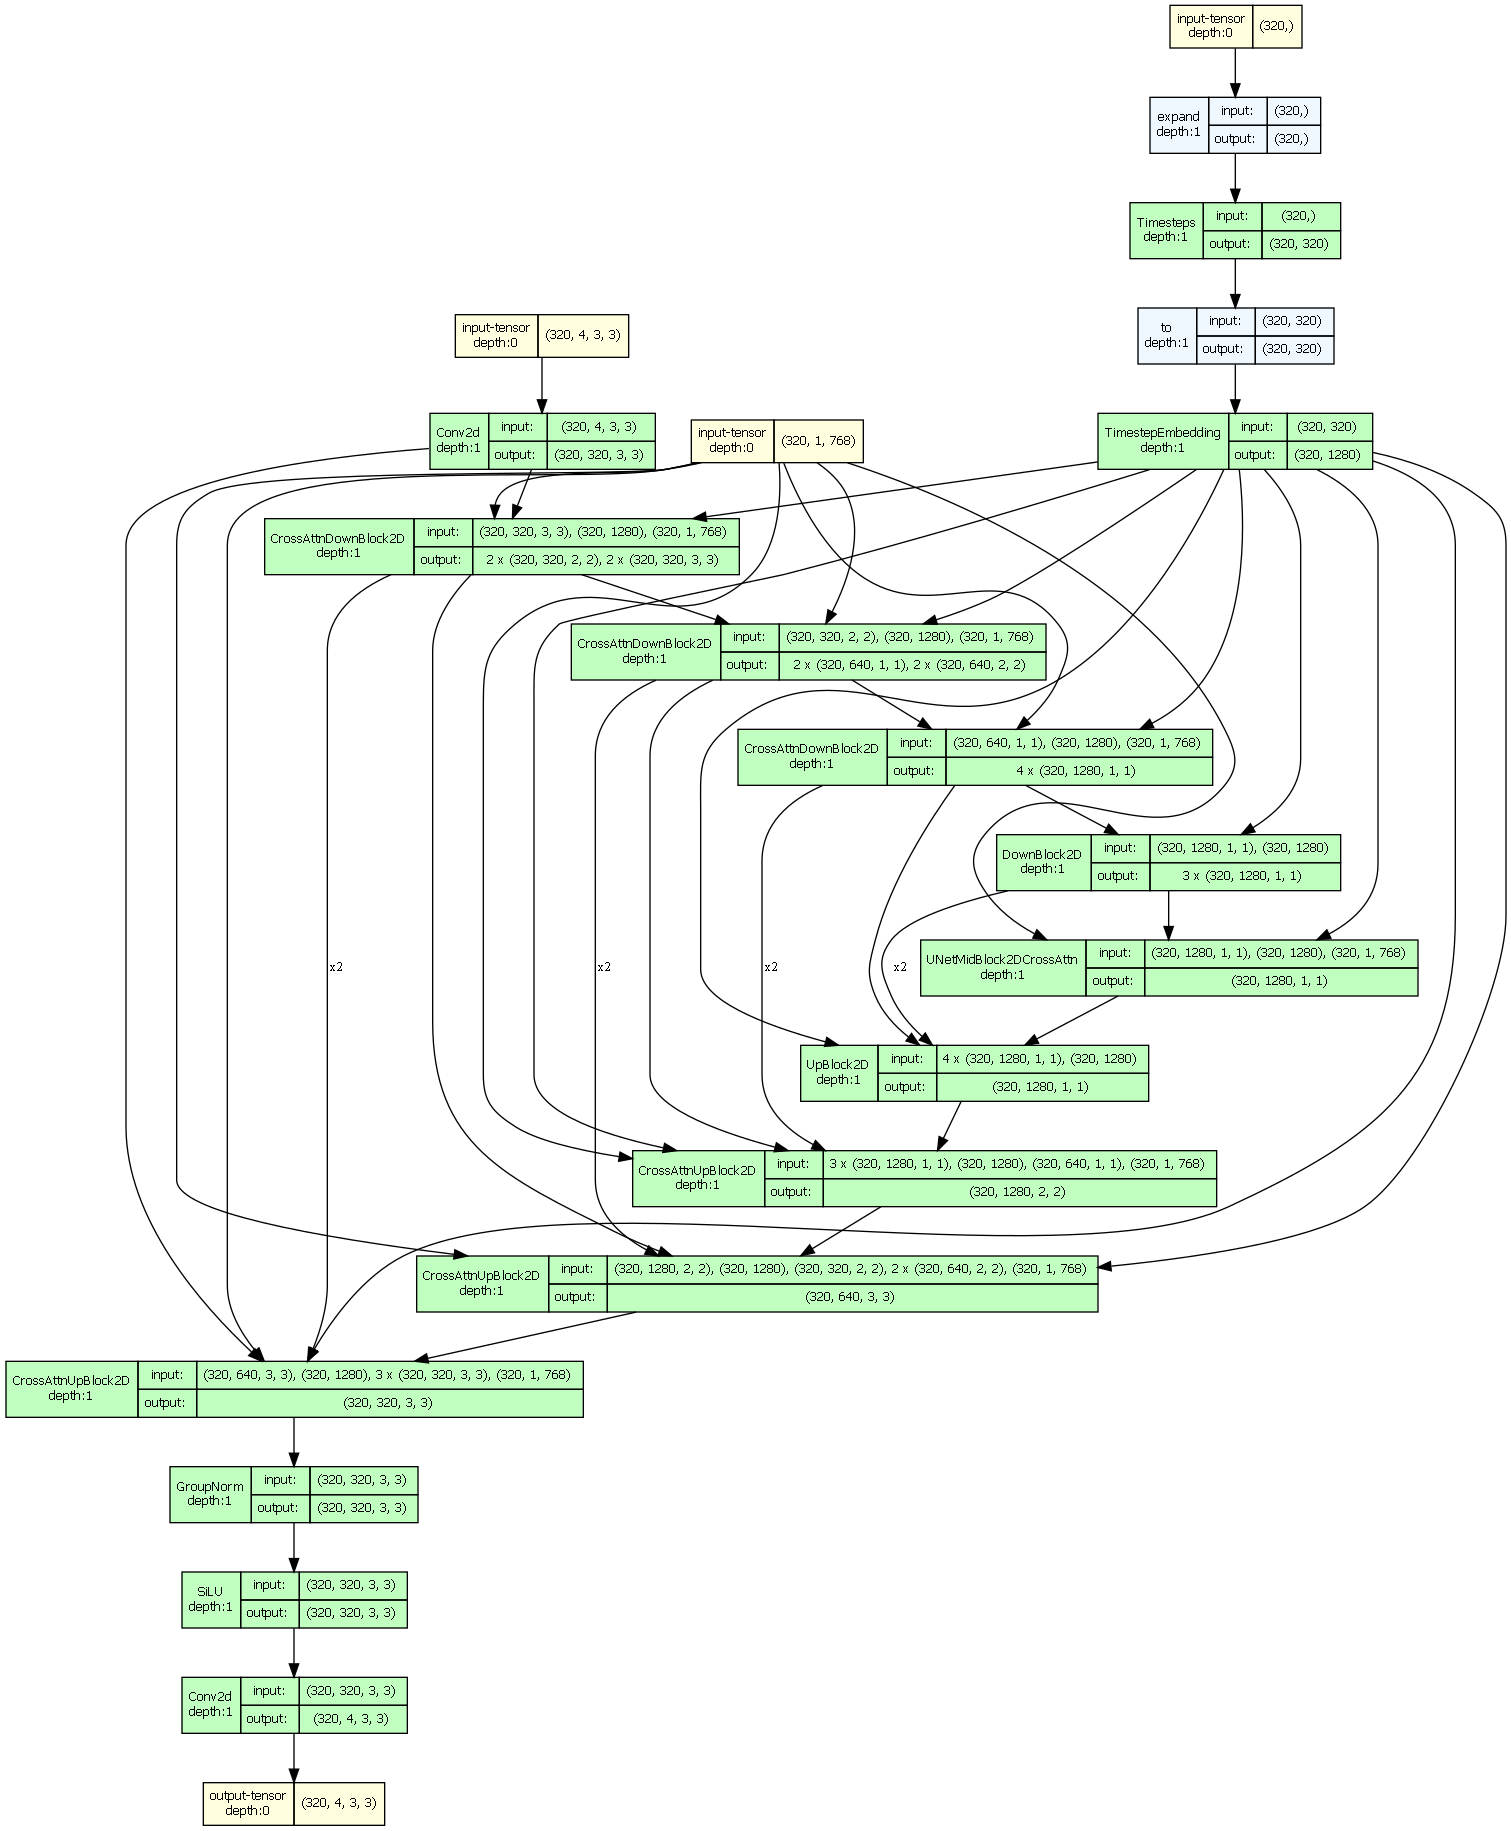

In [42]:
png.visual_graph